# Validation of Base Year

This notebook validates the results of the PyPSA-USA model for the base year against two authoritative datasets: **EIA (U.S. Energy Information Administration)** and **Ember**. The validation covers three key aspects of the electricity system:
- **Electricity Demand**
- **Electricity Generation**
- **Installed Generation Capacity**

### Loading libraries

We begin by importing the necessary libraries for data handling, analysis, and visualization. These include PyPSA for power system analysis, pandas and numpy for data manipulation, geopandas for spatial data, and seaborn/matplotlib for plotting.

---

In [1]:

import os
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


import warnings
warnings.filterwarnings("ignore")

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [18]:
import sys
sys.path.append(os.path.abspath(".."))
from plots.results_validation import (
    load_ember_data, PLOTS_DIR, DATA_DIR, 
    convert_two_country_code_to_three, get_data_EIA, get_demand_pypsa,
    preprocess_eia_data, get_installed_capacity_ember, get_demand_ember,
    preprocess_eia_data_detail, get_generation_capacity_ember_detail
    )

from notebooks._helpers import attach_state_to_buses, compute_demand, attach_grid_region_to_buses

### Loading Files

Here, we load the PyPSA-USA network results for the base year, as well as the relevant EIA and Ember datasets. These datasets provide reference values for demand, generation, and installed capacity, which will be used for validation.

---

In [3]:
# load network
project_root = os.getcwd()
results_dir = os.path.join(project_root, 'results')

# Load Base scenario
base_path = os.path.join(results_dir, 'base_year', "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc")
base_network = pypsa.Network(base_path)
# base_network = pypsa.Network("/Users/gbotemi/Documents/code/PYPSA/US/efuels-supply-potentials/submodules/pypsa-earth/results/US_2021/postnetworks/elec_s_10_ec_lcopt_Co2L-24H_24H_2030_0.071_AB_10export.nc")

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
state_shape_path = "gadm41_USA_1.json"
grid_shape_path = "needs_grid_regions_aggregated.geojson"
attach_state_to_buses(base_network, state_shape_path)
attach_grid_region_to_buses(base_network, grid_shape_path)

In [5]:
country_code = "US"
horizon = 2020

three_country_code = convert_two_country_code_to_three(country_code)

In [6]:
EIA_demand_path = os.path.join(
    DATA_DIR, "validation", "EIA_demands.csv")
EIA_installed_capacities_path = os.path.join(
    DATA_DIR, "validation", "EIA_installed_capacities.csv")
EIA_generation_path = os.path.join(
    DATA_DIR, "validation", "EIA_electricity_generation.csv")

## Generation

In this section, we compare the **annual electricity generation** by technology as reported by PyPSA, EIA, and Ember. This helps to identify any discrepancies in the modeled generation mix and total output.

---

In [7]:
ember_data = load_ember_data()
generation_data_ember = get_generation_capacity_ember_detail(
        ember_data, three_country_code, horizon).round(2)
generation_data_ember.drop(['Load shedding', 'Other Fossil'], inplace=True)

EIA_generation = get_data_EIA(EIA_generation_path, country_code, horizon)
EIA_generation = preprocess_eia_data_detail(EIA_generation).round(2)

In [8]:
ac_balance = base_network.statistics.energy_balance().xs("AC", level=2)
ac_total = (ac_balance[ac_balance>0]/1e6).unstack().sum().rename({
        "CCGT": "Natural gas",  "OCGT": "Natural gas", "Csp": "Solar",
        "biomass EOP": "Biomass", "biomass": "Biomass", "coal": "Coal",
        "oil": "Oil", "urban central gas CHP": "Natural gas", 
        "urban central solid biomass CHP": "Biomass",
        "solar": "Solar", "Run of River": "Hydro", "Reservoir & Dam": "Hydro",
        "Onshore Wind": "Wind", "offwind": "Wind", "Offshore Wind (DC)": "Wind",
    }).to_frame('PyPSA data').groupby(level=0).sum().round(2)

pypsa_gen_final = ac_total[ac_total > 0].dropna()
pypsa_gen_final.drop(['DC'], inplace=True)

In [9]:
generation_df = pd.concat(
    [pypsa_gen_final, generation_data_ember, EIA_generation], axis=1).fillna(0)

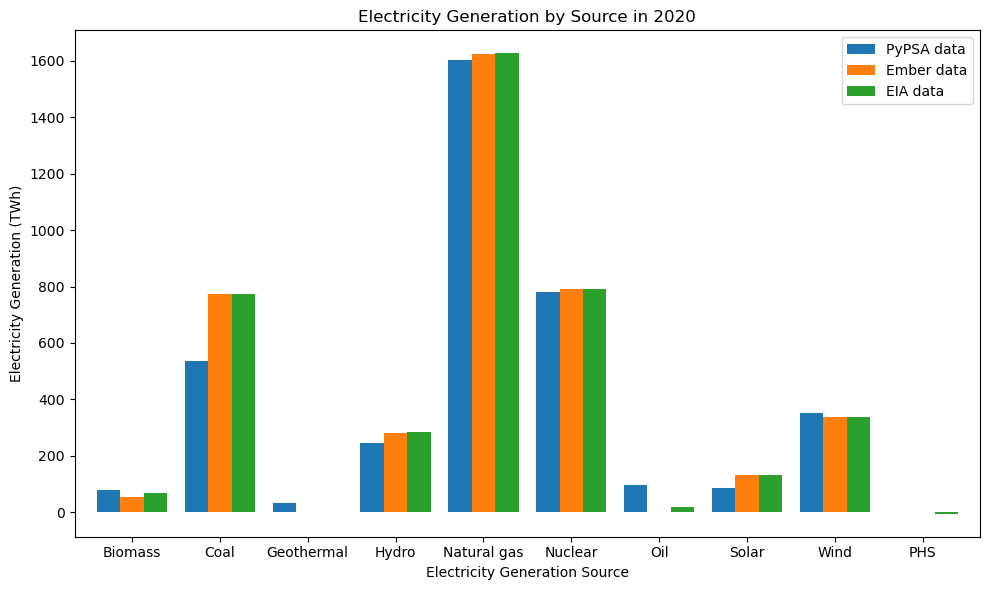

In [10]:
generation_df.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title(f"Electricity Generation by Source in {horizon}")
plt.ylabel("Electricity Generation (TWh)")
plt.xticks(rotation=0)
plt.xlabel("Electricity Generation Source")
plt.legend(loc='upper right')
plt.tight_layout()

# Capacity 

This section validates the **installed generation capacities** by technology. We compare the capacities in the PyPSA network to those reported by EIA and Ember to ensure the model's infrastructure assumptions are consistent with real-world data.

---

In [11]:
installed_capacity_ember = get_installed_capacity_ember(
        ember_data, three_country_code, horizon).round(2)

EIA_inst_capacities = get_data_EIA(
    EIA_installed_capacities_path, country_code, horizon)
EIA_inst_capacities = preprocess_eia_data(EIA_inst_capacities).round(2)

In [12]:
installed_capacity_ember.rename({
    "Gas": "Natural gas"
}, inplace=True)

In [13]:
gen_carriers = {
    "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
    "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam", 'hydro'
}
link_carriers = {
    "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
}

# Generators
gen = base_network.generators.copy()
gen['carrier'] = gen['carrier'].replace({'offwind-ac': 'offwind', 'offwind-dc': 'offwind'})
gen = gen[gen.carrier.isin(gen_carriers)]
gen_totals = gen.groupby('carrier')['p_nom_opt'].sum()

# Storage
sto = base_network.storage_units.copy()
sto = sto[sto.carrier.isin(gen_carriers)]
sto_totals = sto.groupby('carrier')['p_nom_opt'].sum()

# Links (output side scaled by efficiency)
links = base_network.links.copy()
mask = (
    links.efficiency.notnull()
    & (links.p_nom_opt > 0)
    & links.carrier.isin(link_carriers)
)
links = links[mask]
links_totals = links.groupby('carrier').apply(
    lambda df: (df['p_nom_opt'] * df['efficiency']).sum()
)

# Combine all
all_totals = pd.concat([gen_totals, sto_totals, links_totals])
all_totals = all_totals.groupby(all_totals.index).sum()  # Merge duplicates
all_totals = all_totals[all_totals > 0] / 1e3

In [14]:
pypsa_cap = all_totals.rename({
    "onwind": "Wind", "offwind": "Wind",
    "solar": "Solar", "ror": "Hydro", "Reservoir & Dam": "Hydro",
    "geothermal": "Geothermal", "nuclear": "Nuclear", "hydro": "Hydro",
    "OCGT": "Natural gas", "CCGT": "Natural gas", "oil": "Oil",
    "coal": "Coal", "biomass": "Biomass",
}).to_frame('PyPSA data').round(2).groupby(level=0).sum()

In [15]:
installed_capacity_df = pd.concat(
    [pypsa_cap, installed_capacity_ember, EIA_inst_capacities], axis=1).fillna(0)
installed_capacity_df

,PyPSA data,Ember data,EIA data
Biomass,9.01,10.83,16.03
Coal,226.98,233.04,0.00
Geothermal,3.89,0.00,0.00
Hydro,79.98,83.83,79.92
Natural gas,556.69,523.75,0.00
Nuclear,99.96,96.50,96.50
Oil,32.52,0.00,0.00
PHS,22.01,0.00,23.02
Solar,60.39,76.44,75.64
Wind,133.42,118.66,118.38


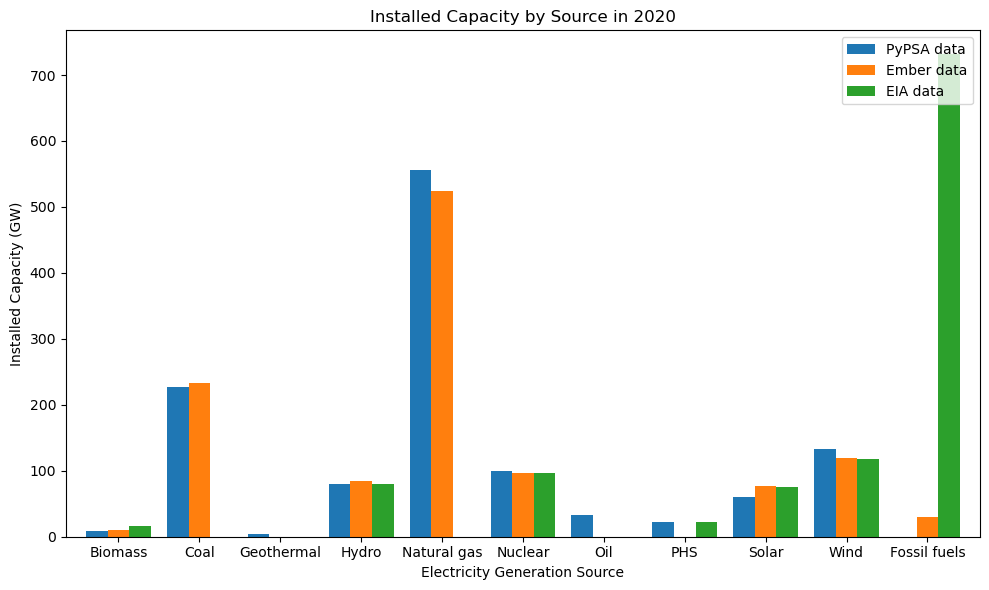

In [16]:
installed_capacity_df.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title(f"Installed Capacity by Source in {horizon}")
plt.ylabel("Installed Capacity (GW)")
plt.xticks(rotation=0)
plt.xlabel("Electricity Generation Source")
plt.legend(loc='upper right')
plt.tight_layout()

# Demand

Finally, we validate the **total electricity demand** in the PyPSA network against the EIA and Ember datasets. This ensures that the modeled demand matches observed values for the base year.

---

In [19]:
demand_ember = get_demand_ember(ember_data, three_country_code, horizon)
pypsa_demand = get_demand_pypsa(base_network)

EIA_demand = get_data_EIA(EIA_demand_path, country_code, horizon)
EIA_demand = EIA_demand.iloc[0, 1]

In [20]:
demand_df = pd.DataFrame(
    {"PyPSA data": [pypsa_demand], "Ember data": [demand_ember], "EIA data": [EIA_demand]})
demand_df.index = ["Demand [TWh]"]
demand_df

,PyPSA data,Ember data,EIA data
Demand [TWh],11756.4274,4090.49,3897.8994


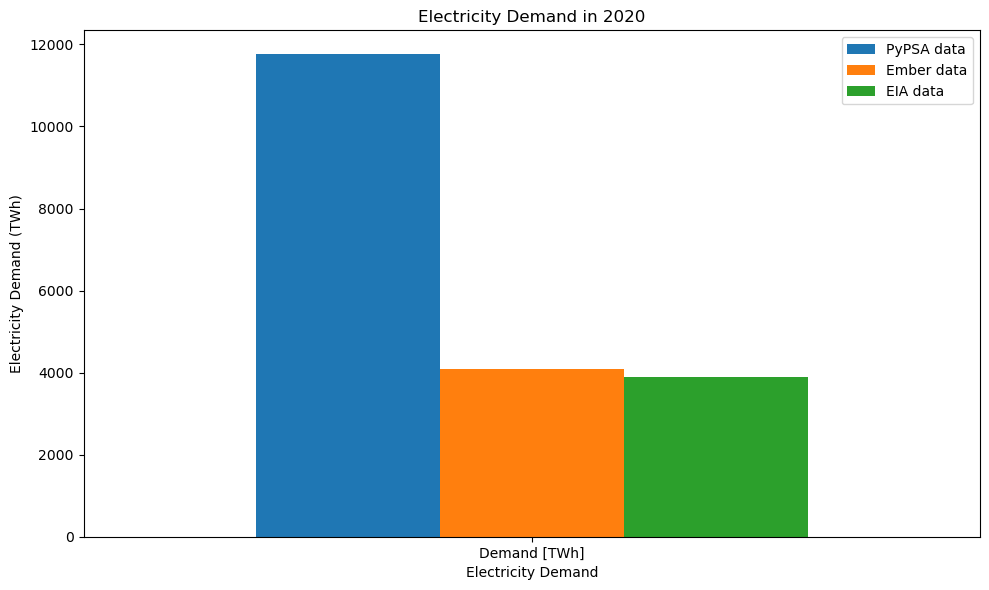

In [21]:
demand_df.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title(f"Electricity Demand in {horizon}")
plt.ylabel("Electricity Demand (TWh)")
plt.xticks(rotation=0)
plt.xlabel("Electricity Demand")
plt.legend(loc='upper right')
plt.tight_layout()

### State-wise Total Electricity Demand (Validation Year)
*A bar plot showing the total annual electricity demand for each state or region for the validation year. This helps confirm the spatial distribution of demand.*

In [22]:
base_demand_grid_region, base_demand_state = compute_demand(base_network)

In [23]:
base_demand_grid_region.T

region,Alaska,California,Delta,Florida,Hawaii,Mid-Atlantic,Midwest,Mountain,New England,New York,Northwest,Plains,Southeast,Southwest,Texas
carrier,,,,,,,,,,,,,,,
AC,0.79,93.45,62.43,86.00,3.21,294.25,175.19,49.63,31.86,68.20,64.13,112.19,224.31,56.55,149.50
agriculture electricity,0.06,5.55,1.62,2.17,0.25,10.13,7.09,3.56,1.76,4.36,2.50,3.98,8.33,2.30,3.64
industry electricity,1.10,69.15,38.91,17.47,3.36,153.96,88.76,36.51,26.10,67.34,26.61,48.15,77.29,18.16,59.59
land transport EV,0.08,6.66,1.90,2.49,0.29,12.41,8.81,4.44,2.20,5.42,3.11,4.83,9.86,2.75,4.25
rail transport electricity,0.01,0.54,0.16,0.21,0.02,0.97,0.69,0.34,0.17,0.43,0.24,0.40,0.80,0.23,0.35
services electricity,0.71,85.03,56.79,78.25,2.92,267.71,159.39,45.15,28.98,62.05,58.34,102.08,204.06,51.45,136.01


In [24]:
base_demand_state.T

region,AK,AL,AR,AZ,CA,CO,FL,GA,HI,IA,...,SC,SD,TN,TX,UT,VA,WA,WI,WV,WY
carrier,,,,,,,,,,,,,,,,,,,,,
AC,0.79,30.60,11.03,31.64,100.66,23.92,90.43,64.14,3.21,27.06,...,30.88,3.34,46.67,173.38,11.57,40.06,29.09,27.56,12.66,4.66
agriculture electricity,0.06,0.70,0.22,0.99,7.12,1.38,3.06,2.46,0.25,0.91,...,1.11,0.17,1.65,4.39,0.35,0.94,1.01,1.41,0.48,0.08
industry electricity,1.10,9.75,2.40,6.68,84.92,12.93,24.83,19.77,3.36,11.01,...,9.29,2.08,18.06,67.37,3.25,11.06,13.95,16.03,8.96,1.48
land transport EV,0.08,0.82,0.26,1.17,8.60,1.72,3.53,2.90,0.29,1.12,...,1.31,0.22,1.98,5.14,0.44,1.14,1.25,1.79,0.59,0.11
rail transport electricity,0.01,0.07,0.02,0.10,0.69,0.13,0.30,0.23,0.02,0.09,...,0.11,0.02,0.16,0.42,0.03,0.09,0.10,0.13,0.05,0.01
services electricity,0.71,27.84,10.03,28.79,91.59,21.77,82.28,58.35,2.92,24.62,...,28.09,3.04,42.46,157.73,10.52,36.45,26.46,25.07,11.52,4.24


In [25]:
fig1 = px.bar(base_demand_grid_region, barmode='stack', text_auto='.1f')
fig1.update_layout(width=1100, yaxis_title='Demand (TWh)', xaxis_title='Grid region', title='Electricity demand by type of load and Grid region (2023)')
fig1.show()

fig1 = px.bar(base_demand_state, barmode='stack', text_auto='.1f')
fig1.update_layout(width=3000, yaxis_title='Demand (TWh)', xaxis_title='State', title='Electricity Demand by type of load and State (2023)')
fig1.show()

In [26]:
def preprocess_eia_demand(path):
    statewise_df = pd.read_excel(path, sheet_name="Data")

    demand_df = statewise_df.loc[statewise_df['MSN'] == 'ESTXP']
    demand_df.set_index('State', inplace=True)
    
    # data is in million kWh (GWh) - hence dividing by 1e3 to get the data in TWh
    demand_df_2021 = demand_df[2021] / 1e3
    demand_df_2021 = demand_df_2021.to_frame()
    demand_df_2021.columns = ["EIA"]

    demand_df_2021.drop(["US"], axis=0, inplace=True)


    return demand_df_2021

In [27]:
eia_statewise_demand_path = "../data/validation/EIA_statewise_data/use_all_phy.xlsx"
eia_statewise_demand = preprocess_eia_demand(eia_statewise_demand_path)

In [28]:
demand_total =  pd.concat([eia_statewise_demand, base_demand_state.sum(axis=1)], axis=1).rename({0: 'PyPSA'}, axis=1)

In [29]:
demand_total.sum()

EIA      3805.873
PyPSA    3675.430
dtype: float64

In [30]:
fig = px.bar(demand_total,barmode='group')
fig.update_layout(width=1000, yaxis_title='Annual electricity demand (TWh)')
fig.show()